In [7]:
import matplotlib.pyplot as plt
import torch
from torchvision import transforms
from torchvision.datasets import CIFAR10
import torch.nn as nn
import data_utils

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
plt.rcParams.update({'font.size': 12})
device

device(type='cuda')

In [9]:
DATA_DIR = '/datasets/cv_datasets/data'
ds_train = CIFAR10(root=DATA_DIR, download=True, train=True, transform=None)
ds_test = CIFAR10(root=DATA_DIR, download=True, train=False, transform=None)
dl_train, dl_val, dl_test = data_utils.get_data_loaders(train_dataset=ds_train, test_dataset=ds_test, batch_size=128)

Files already downloaded and verified
Files already downloaded and verified


In [10]:
from cifar10 import encoder

encoder = encoder.encoder_cifar()

projection_head = nn.Sequential(
    nn.Linear(128, 128),
    nn.ReLU(),
    nn.Linear(128, 128)
)

model = nn.Sequential(
    encoder,
    projection_head
).to(device)

In [ ]:

import training

try:
    encoder.load_state_dict(torch.load('saved_models/encoder_contrastive_cifar.pth'))
except:
    transform = transforms.Compose([
                transforms.RandomResizedCrop(32, scale=(0.08, 1.0)),#0.08
                transforms.RandomHorizontalFlip(p=0.5),
                transforms.RandomApply(
                    [transforms.ColorJitter(0.4, 0.4, 0.4, 0.1)],
                    p=0.8
                ),
                transforms.RandomGrayscale(p=0.2),
                transforms.RandomApply([
                        transforms.GaussianBlur(kernel_size=3)
                    ], p=0.5),
            ])
    normalize = transforms.Normalize(mean=[0.49139968, 0.48215841, 0.44653091], std=[0.24703223, 0.24348513, 0.26158784])
    num_epochs = 200
    optimizer = torch.optim.Adam(model.parameters(), lr=2e-4)
    contrastive_trainer = training.ContrastiveTrainer(model=model,
                                                      device=device,
                                                      num_epochs=num_epochs,
                                                      optimizer=optimizer,
                                                      transform=transform,
                                                      normalize=normalize,
                                                      temperature=0.15)
    contrastive_trainer.train(dl_train=dl_train, dl_val=dl_val)

    torch.save(encoder.state_dict(), 'saved_models/encoder_contrastive_cifar.pth')
    torch.save(model.state_dict(), 'saved_models/model_contrastive_cifar.pth')

In [ ]:
from utils import plot_tsne

plot_tsne(model=encoder, dataloader=dl_test, device=device, name='contrastive_cifar10')

In [13]:
from cifar10 import classifier

classifier = classifier.ClassifierCifar().to(device)
model = nn.Sequential(encoder, classifier).to(device)
loss_fn = torch.nn.CrossEntropyLoss()

In [14]:
for param in list(encoder.parameters()):
    param.requires_grad = False
for param in list(classifier.parameters()):
    param.requires_grad = True

--- EPOCH 1/30 ---
  0%|                                                                                                           | 0/352 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 352/352 [00:25<00:00, 13.73it/s]
Train loss: 1.275139501487667, accuracy: 55.15161380171776
100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 23.65it/s]
Validation loss: 1.1445394530892372, accuracy: 60.15625
Best model saved at epoch 1 with validation loss: 1.1445394530892372
--- EPOCH 2/30 ---
100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 352/352 [00:24<00:00, 14.20it/s]
Train loss: 1.107503804462877, accuracy: 60.5350378731435
100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 24.18it/s]
Validation loss: 1.047770546376705, accuracy: 62.83203125
Best model saved at epoch 2 with validation loss: 1.047770546376705
--- EPOCH 3/30 ---
100%|█████████████████████████████████████████

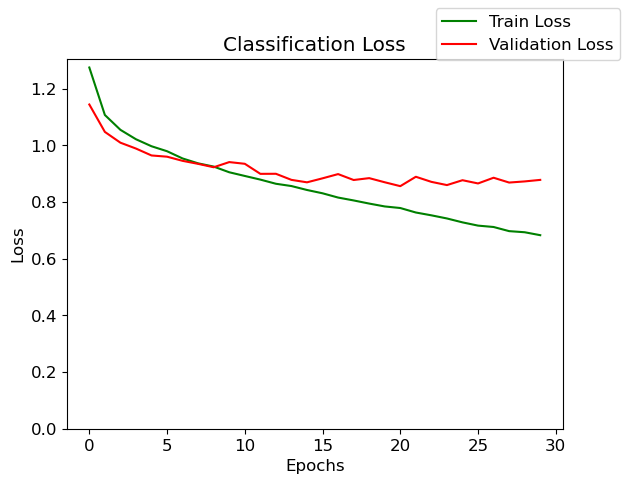

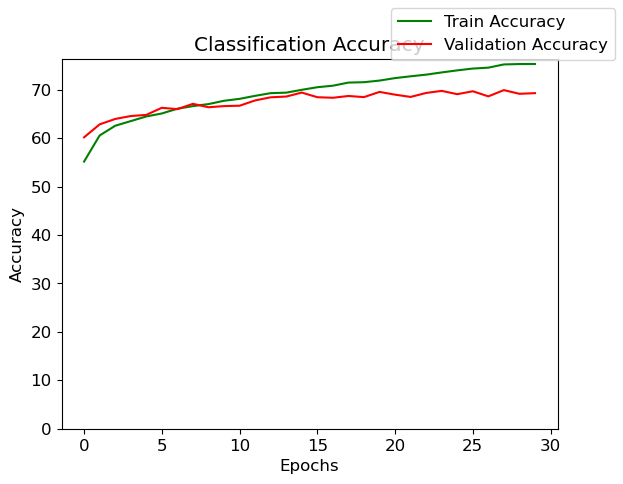

100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:03<00:00, 23.82it/s]
Test loss: 0.8916163452063934, accuracy: 69.64992088607595
WOW! :)


In [ ]:
import training

try:
    classifier.load_state_dict(torch.load('saved_models/classifier_contrastive_cifar.pth'))
except:
    optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)
    loss_fn = nn.CrossEntropyLoss()
    transform = transforms.Compose([
        transforms.RandomResizedCrop(32, scale=(0.8, 1.0)),
        transforms.RandomHorizontalFlip(p=0.5),
    ])
    normalize = transforms.Normalize(mean=[0.49139968, 0.48215841, 0.44653091], 
                                     std=[0.24703223, 0.24348513, 0.26158784])

    trainer = training.ClassifierTrainer(model=model,
                                        optimizer=optimizer,
                                        loss_fn=loss_fn,
                                        device=device,
                                        transform=transform,
                                        normalize=normalize)
    trainer.train(num_epochs=30, dl_train=dl_train, dl_val=dl_val)
    trainer.test(dl_test)
    
    torch.save(classifier.state_dict(), 'saved_models/classifier_contrastive_cifar.pth')